# Chapter 02 - Data Preprocessing

The API we will use most in this lecture is a python API called Scikit-Learn. The main design principles are:
- Objects that estimate parameters are called **estimators**. The estimation is performed by the `fit()` method, and it takes only a dataset as a parameter (or dataset + labels for supervised datasets).
- Estimators that can transform datasets are called **transformers**. If there are parameters to learn, you first learn those with the  `fit()` method as above. Then the transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. There is also an optimized method called `fit_transform()`` which combines the above.
- Estimators that can make predictions from data are called **predictors**. A predictor hast a `predict()` method that takes a dataset and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions, given a test set and a performance measure $P$.
- learnable parameters can be accessed via attributes. To show that these parameters were learned by the estimator, these attributes end in "_". 


We will show how to preprocess data in an example. Here, we use the `titanic` dataset from OpenML. 
We want to predict whether someone survived or not. 

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

# Load data (e.g. as pandas DataFrame)

input = fetch_openml('titanic', version=1, as_frame=True)['data']
labels = fetch_openml('titanic', version=1, target_column = 'survived', as_frame=True, )['target']
df = pd.concat([input, labels], axis=1)

## 1st step: Visualisations and understanding the data

### 1.1 Getting to now the data structure

Each column of df apart from survived is called a **feature**. "survived" is the **target/label** we want to predict.
One line of this dataset is one **instance**.  

What are the features? Let's look at the first lines:

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0




Here is some info about the dataset: 


|Variable |Definition	|Key|Type|
|---|---|---|---|
|survival |Survival |	0 = No, 1 = Yes|categorical (nominal)|
|pclass |Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd|categorical (nominal)|
|name|Passenger name| -|string|
|sex |Sex |female/male| categorical (nominal)|
|Age |Age in years |Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5|numeric|
|sibsp |number of siblings or spouses aboard the Titanic |-|numeric|
|parch |number of parents or children aboard the Titanic |-|numeric|
|ticket |Ticket number 	|-|string|
|fare |	Passenger fare 	|-|numeric|
|cabin |Cabin number |-|	string|
|embarked |Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton|categorical (nominal)|
|boat|life-boat, if survived|-|string|
|body|body number, if not survived and body was recovered|-|numeric|
|home.dest|home/destination|-|string|



Take a look at data structure: datatypes and number of
non-null-values for each feature. 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(6), object(5)
memory usage: 116.8+ KB


Some of the columns are numerical, some are categorical (ordinal (ordered) or nominal (no order)): 
|Variable |Numerical|Categorical: Ordinal|Categorical: Nominal|
|:---|:---|:---|:---|
||||
|pclass |	|||
|sex ||||
|Age |	|||
|sibsp |	|||
|parch |	|||
|ticket |	|||
|fare |	|||
|cabin |		|||
|embarked |	|||


Look at summary statistics with: max, min, mean... for all numerical features. 

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Find out if there are missing values:

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
survived        0
dtype: int64

There are a lot of missing data in some features (e.g. body, home.dest...). 
Question: Is that a problem? examples: 
- boat: naturally NaN for everyone who did not survive!
- body: naturally NaN for everyone who did survive or whose body was not discovered.
- age: here, missing data might be problematic for a prediction. 

Usually, one deals with missing data LATER. (Reason: see later).

### 1.2 Plot feature distributions and check class (im)balance

histogram, class balance, correlations, scatterplots and everything from Data Science 2

Remember Data Science 2! 


First step: plot histograms. However, note that this will only plot numerical data!


array([[<AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>],
       [<AxesSubplot:title={'center':'fare'}>,
        <AxesSubplot:title={'center':'body'}>]], dtype=object)

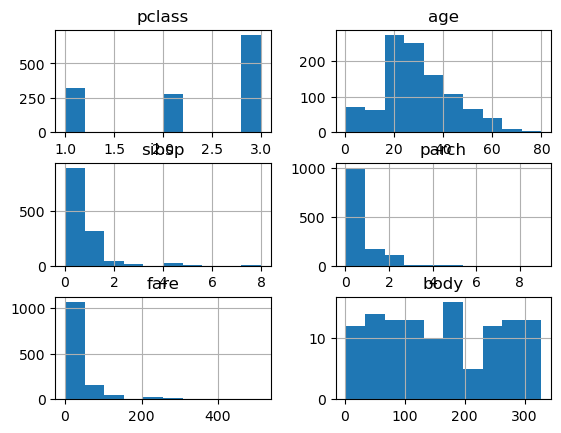

**Question**: what are the distributions?

  

Check average fare per pclass and the standard deviation of fares per class:

Text(0, 0.5, 'standard deviation of fare')

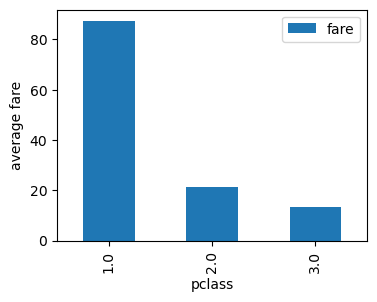

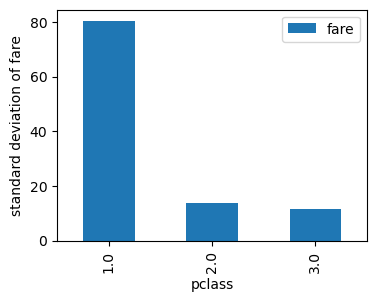

In [108]:
ax1= df[['pclass','fare']].groupby('pclass').mean().plot(kind='bar', figsize = [4,3])
ax1.set_ylabel('average fare')
ax2=df[['pclass','fare']].groupby('pclass').std().plot(kind='bar', figsize = [4,3])
ax2.set_ylabel('standard deviation of fare')


**Result:**


Next we plot class distributions for all categorical values ('sex', 'embarked', most importantly the target: 'survived') and check for **class (im)balance**:

<AxesSubplot:>

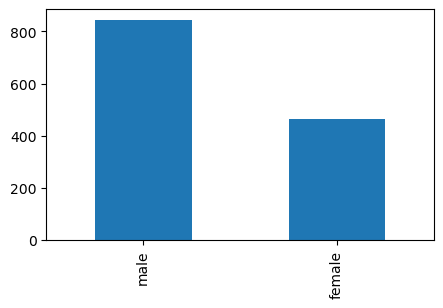

In [109]:
df['sex'].value_counts().plot(kind='bar', figsize=[5,3])

<AxesSubplot:>

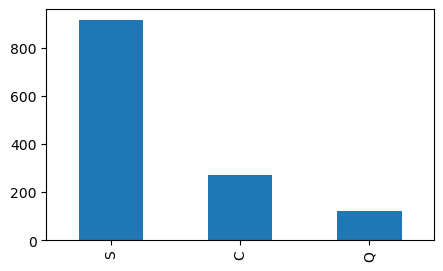

In [110]:
df['embarked'].value_counts().plot(kind='bar', figsize=[5,3])

<AxesSubplot:>

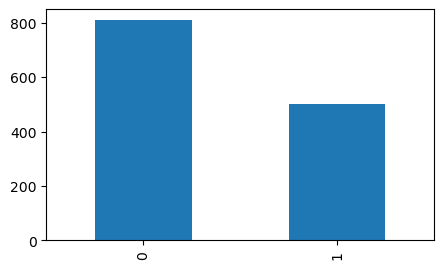

In [111]:
df['survived'].value_counts().plot(kind='bar', figsize=[5,3])

**Result:**
- class imbalance wrt pclass (approx. double the amount of 3rd class tickets than 1st and 2nd);
- class imbalance wrt sex (more male than female passengers)
- class imbalance wrt port where passengers embarked
- class imbalance wrt target survived: less survived than didn't

**What to do?**


### 1.3 Correlations and Scatterplots to find out how different features are related

Look for dependencies of the features (correlations): compute the correlations coeﬃcients:

In [112]:
df.corr().style.background_gradient(cmap='Reds')

/var/folders/q9/pzd7t_6s2vj1dd9v3l9w99zr0000gq/T/ipykernel_73709/3686770038.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='Reds')


,pclass,age,sibsp,parch,fare,body
pclass,1.000000,-0.408106,0.060832,0.018322,-0.558629,-0.034642
age,-0.408106,1.000000,-0.243699,-0.150917,0.178739,0.058809
sibsp,0.060832,-0.243699,1.000000,0.373587,0.160238,-0.099961
parch,0.018322,-0.150917,0.373587,1.000000,0.221539,0.051099
fare,-0.558629,0.178739,0.160238,0.221539,1.000000,-0.043110
body,-0.034642,0.058809,-0.099961,0.051099,-0.043110,1.000000


**Some Results:**


To see the reationship between features, one could also draw scatterplot matrices for the numerical features, e.g. for pclass, age and sibsp: 

array([[<AxesSubplot:xlabel='pclass', ylabel='pclass'>,
        <AxesSubplot:xlabel='age', ylabel='pclass'>,
        <AxesSubplot:xlabel='sibsp', ylabel='pclass'>],
       [<AxesSubplot:xlabel='pclass', ylabel='age'>,
        <AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='sibsp', ylabel='age'>],
       [<AxesSubplot:xlabel='pclass', ylabel='sibsp'>,
        <AxesSubplot:xlabel='age', ylabel='sibsp'>,
        <AxesSubplot:xlabel='sibsp', ylabel='sibsp'>]], dtype=object)

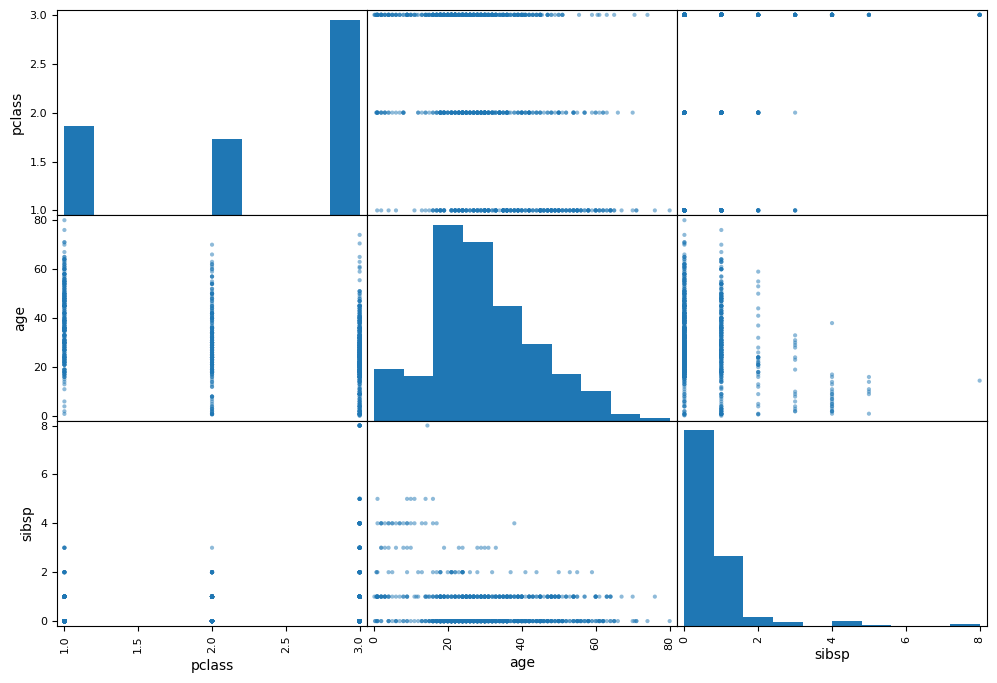

In [113]:
from pandas.plotting import scatter_matrix

attributes = ["pclass", "age", "sibsp"]
scatter_matrix(df[attributes], figsize=(12 , 8))

**Results:** (diagonal plots are just histograms as above! - scatterplots would be just straight lines)



### 1.4 Get insights wrt target value


We want to predict if someone survived or not, so we focus on the target feature for further visualizations, e.g.: 
- Percentage of survivors according to sex
- percentage of survivors by age group

<AxesSubplot:>

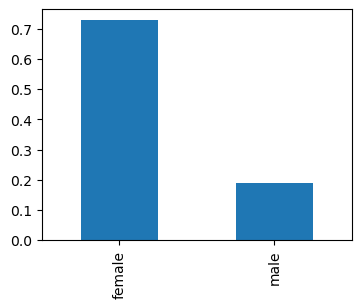

In [114]:
survivors = df[df['survived']=="1"]

(survivors['sex'].value_counts()/df['sex'].value_counts()).plot(kind='bar', figsize=[4,3])

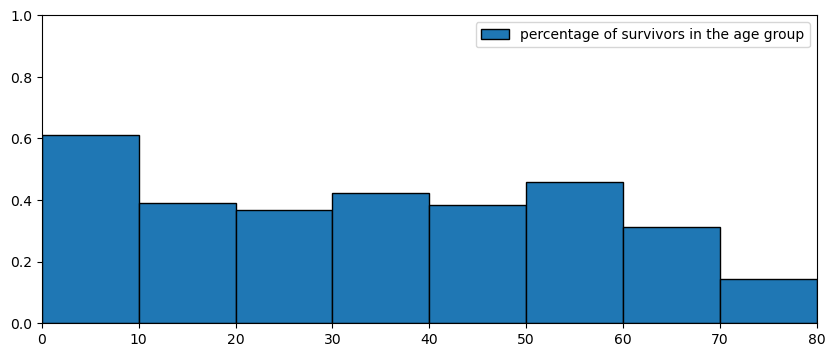

In [115]:
xs = [10*i for i in range(8)]
ys = []
for i in range(8):
    age_group = df[(df['age'] < xs[i]+10)&(df['age'] >= xs[i])]
    age_group_surv = age_group[age_group['survived']=="1"]
    ys.append(len(age_group_surv)/len(age_group))
plt.figure(figsize=[10,4])
plt.bar(xs, ys, width = 10, align='edge', edgecolor='black', label='percentage of survivors in the age group')
plt.ylim([0,1])
plt.xlim([0,80])
plt.legend()

## 2nd Step: Feature engineering

- **Feature selection:** Drop irrelevant features, if there are any
- **Feature extraction:** combine existing features to produce a more useful one. e.g. Experiment with attribute combinations and ﬁnd out if they are useful by repeating step 1 (Data Visualizations, correlation matrix). 
  
In this case: 
- Feature selection: 
  - name, ticket number, cabin number: ?
  - body and boat: ?
  - home.dest has many missing values -> drop 
- Feature extraction: how many siblings or parents/children are travelling with a passenger could be combined to a single feature 'family', and we could add a feature showing if a passenger travelled alone (1) or not (0). 

In [116]:
for feature in ['name', 'ticket', 'cabin', 'body', 'boat', 'home.dest']:
    df.drop(feature, axis=1, inplace=True) 

df['family'] = df['sibsp'] + df['parch']
df.loc[df['family'] > 0, 'travelled_alone'] = 0
df.loc[df['family'] == 0, 'travelled_alone'] = 1
df.head()


,pclass,sex,age,sibsp,parch,fare,embarked,survived,family,travelled_alone
0,1.0,female,29.0000,0.0,0.0,211.3375,S,1,0.0,1.0
1,1.0,male,0.9167,1.0,2.0,151.5500,S,1,3.0,0.0
2,1.0,female,2.0000,1.0,2.0,151.5500,S,0,3.0,0.0
3,1.0,male,30.0000,1.0,2.0,151.5500,S,0,3.0,0.0
4,1.0,female,25.0000,1.0,2.0,151.5500,S,0,3.0,0.0


<AxesSubplot:title={'center':'Passenger travelled alone?'}>

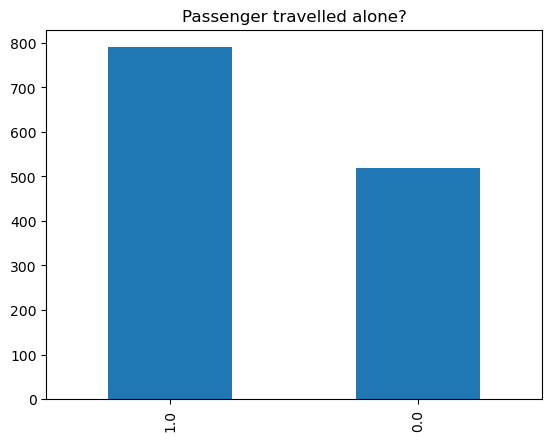

In [117]:
df['travelled_alone'].value_counts().plot(title='Passenger travelled alone?',kind='bar')

## 3rd Step: Train-Test Split and Input-Label-Split

The next step is to divide the data into train and test set, e.g. you could take 80% of data for training and keep 20% of data for testing.

**Question:** Why do we split the data now and not AFTER data cleaning, e.g. filling in missing values with the mean?

**Answer:** ?????

So: **Always split into train and test set BEFORE you modify the data!**

It is important to randomly permute the data in the dataset before we make the split! Why?

Example: an ordered set of images of handwritten digits 0-9 (training set would be 0-7, test set 8&9) 

One can permute and split "by hand", or use Scikit-Learn's `train_test_split'.

In [118]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

test_set.head()

,pclass,sex,age,sibsp,parch,fare,embarked,survived,family,travelled_alone
1148,3.0,male,35.0,0.0,0.0,7.1250,S,0,0.0,1.0
1049,3.0,male,20.0,1.0,1.0,15.7417,C,1,2.0,0.0
982,3.0,male,NaN,0.0,0.0,7.8958,S,0,0.0,1.0
808,3.0,male,NaN,0.0,0.0,8.0500,S,0,0.0,1.0
1195,3.0,male,NaN,0.0,0.0,7.7500,Q,0,0.0,1.0


Problem: The random permutation could still put all 0's into the test set! 
Or in this example: put only survivors into the test set.
This would be called a **data mismatch**.

Solution: A **stratified split** evenly distributes the classes of one specified feature between train and test set - (i.e. if there are 10% images of handwritten 0's in the original dataset, the ratio of 0's is also 10% in training and test set).

Here: should make sure that there are as many survivors in the train and test as in the original set! There are several options for a stratified split with Scikit-Learn: 
either: 
- set the option `stratify = df['survived']` in sklearn's train-test-split above, or:
- Use Sklearn's StratifiedShuffleSplit (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [119]:
from sklearn.model_selection import StratifiedShuffleSplit

shufflesplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_id, test_id in shufflesplit.split(df, df['survived']):
    train = df.loc[train_id]
    test_set = df.loc[test_id]

Next, to separate input data from labels: 


In [120]:
train_labels = train_set['survived']
test_labels = test_set['survived']

#keep the original train set, see why later
train_full = train_set.copy()

for set_ in (train_set, test_set):
    set_.drop('survived', axis=1, inplace=True)

## 4th Step: Data Cleaning 

Make sure there are no wrong, missing or unneccessary data: get rid of features, set some (missing) values to some value (zero, the mean= Mittelwert, the median=Zentralwert, ...), or drop data. 

Ways to clean data:
?????


Let us create a dataframe with only the incomplete rows to "play around with" for dropping data:

In [121]:
incomplete_rows = train_set[train_set.isnull().any(axis=1)]
incomplete_rows.head()

,pclass,sex,age,sibsp,parch,fare,embarked,family,travelled_alone
147,1.0,male,NaN,0.0,0.0,42.4000,S,0.0,1.0
983,3.0,male,NaN,0.0,0.0,7.5500,S,0.0,1.0
900,3.0,male,NaN,1.0,2.0,23.4500,S,3.0,0.0
277,1.0,female,NaN,1.0,0.0,146.5208,C,1.0,0.0
1073,3.0,male,NaN,0.0,0.0,7.7500,Q,0.0,1.0


In [122]:
# Drop the instances with missing values in the cabin feature



,pclass,sex,age,sibsp,parch,fare,embarked,family,travelled_alone
1225,3.0,male,60.5,0.0,0.0,NaN,S,0.0,1.0
284,1.0,female,62.0,0.0,0.0,80.0,NaN,0.0,1.0


In [123]:
# Drop the entire cabin feature



,pclass,sex,sibsp,parch,fare,embarked,family,travelled_alone
147,1.0,male,0.0,0.0,42.4000,S,0.0,1.0
983,3.0,male,0.0,0.0,7.5500,S,0.0,1.0
900,3.0,male,1.0,2.0,23.4500,S,3.0,0.0
277,1.0,female,1.0,0.0,146.5208,C,1.0,0.0
1073,3.0,male,0.0,0.0,7.7500,Q,0.0,1.0


In [124]:
# Filling in the median for missing age values



/var/folders/q9/pzd7t_6s2vj1dd9v3l9w99zr0000gq/T/ipykernel_73709/472097065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_rows['age'].fillna(median, inplace=True)


,pclass,sex,age,sibsp,parch,fare,embarked,family,travelled_alone
147,1.0,male,28.0,0.0,0.0,42.4000,S,0.0,1.0
983,3.0,male,28.0,0.0,0.0,7.5500,S,0.0,1.0
900,3.0,male,28.0,1.0,2.0,23.4500,S,3.0,0.0
277,1.0,female,28.0,1.0,0.0,146.5208,C,1.0,0.0
1073,3.0,male,28.0,0.0,0.0,7.7500,Q,0.0,1.0


In [125]:
# To use SimpleImputer one needs a copy of the dataframe with only the numerical features with missing values

train_num = train_set[['age','fare']]

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy='median')
imputer.fit(train_num)   # computes all median values, but doesn't transform the dataset!
X = imputer.transform(train_num) # this fills in the missing values with the mean.
train_num_imputed = pd.DataFrame(X, columns=train_num.columns,
						index=train_num.index)
train_num_imputed.head()

# Then you could replace the features in the original dataframe.

,age,fare
772,17.0,7.8958
543,36.0,10.5000
289,18.0,79.6500
10,47.0,227.5250
147,28.0,42.4000


Question: What would work better for fare?
Answer: Compute the medium fare for each class and impute those!

### Note: Getting rid of outliers

Most data contain "bad" instances (e.g faulty data, sensor malfunction, ...) that lie "outside" of the "normal" data ranges. To get rid of those, you first have to identify them (statistical methods e.g. box plots for all features, or "Anomaly Detection", see later). 


## Step 5: Handling Categorical Features

Examples in our dataset: 
pclass (1,2,3), sex (female/male), embarked (C,Q,S)

For an algorithm to be able to deal with categorical data, they need to be transformed to numerical data somehow. There are two main optins: 

### Ordinal Encoding

transform each alass into a number. 
e.g.: female = 0, male = 1, 
C = 0, Q = 1, S = 2 ...

Problem: ???????

Output: numpy ndarray

In [126]:
from sklearn.preprocessing import OrdinalEncoder

train_emb = train_set[['embarked']]
ordinal_encoder = OrdinalEncoder()
train_emb_encoded = ordinal_encoder.fit_transform(train_emb)
train_emb_encoded[:10]



array([[2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.]])

### better: One-Hot Encoding

Suppose you have $C$ different classes $1, 2, \ldots, C$. Then the **one-hot vector** representing class $i\in \{1,\ldots, C\}$ is the unit vector
$$
		e_i:=\left(\begin{array}{c}0 \\\vdots \\0 \\1 \\0 \\\vdots \\0\end{array}\right)\leftarrow i\text{-th entry}
$$

Advantage: 
For $c$ classes $1,2,3,4,\ldots$, the distance between any two different one-hot-vectors is the same:
$$||e_i-e_j||=\sqrt{2}.$$ 

The output is a SciPy sparse matrix instead of numpy array; if you want a normal numpy array set `sparse=False``.

One Hot Encoding turns one categorical feature (with $C$ categories) into $C$ columns. 


In [127]:
from sklearn.preprocessing import OneHotEncoder

train_emb = train_set[['embarked']]
cat_encoder = OneHotEncoder(sparse=False)
train_emb_1hot = cat_encoder.fit_transform(train_emb)
print(train_emb_1hot)

# Get the list of categories: 

cats_1hot = list(x for x in cat_encoder.categories_[0])
print(cats_1hot)

# Note: We now have 4 categories because we have not cleaned the data yet!


[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
['C', 'Q', 'S', nan]


## 6th step: Feature Scaling

Most ML algorithms don't perform well when the input numerical attributes have very different scales (for example if one feature is around $0.00000001$, while the other feature is around a million): the patterns in the data get very "distorted" and hard to find for the algorithm. $\Rightarrow$ **feature scaling**. 

There are two ways to get all attributes to the same scale:
- **Min-max scaling**: values are shifted and rescaled so that they end up in the range of 0 to 1, by substracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler.
- **Standardization**: substract the mean value and divide by standard deviation so values have mean 0 and 1 variance. Unlike minmax scaling, standardization doesn't bound values to a specific range. Scikit-Learn provides a transformer called StandardScaler.

## Step 7: Creating Class Balance

Remember that there is a class imbalance in the labels, so we want to create class balance only on the training set via under- or oversampling.

We will now create balanced datasets by
- subsampling survived == 0, or
- oversampling survived == 1:

In [143]:
# First subsampling: here we still need the full train set incl. labels

# Lets shuffle the data before creating the subsamples

train_shuffled = train_full.sample(frac=1)

# create two separate dataframes of same length for survived and deceased
sur_train = train_shuffled.loc[train_shuffled['survived'] == '1']
num_instances = len(sur_train)
dec_train = train_shuffled.loc[train_shuffled['survived'] == '0'][:num_instances]
print(len(sur_train), len(dec_train))

train_sub = pd.concat([sur_train, dec_train])

# Shuffle dataframe rows
train_sub = train_sub.sample(frac=1, random_state=42)


382 382


Next, Oversampling: There are different ways, the most naive is Naive random over-sampling, which we do here. 

To use oversampling techniques, you can use the package imbalanced-learn: https://imbalanced-learn.org/stable/, imported as imblearn. 



In [144]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_over, y_over = ros.fit_resample(train_set, train_labels)

print(y_over.value_counts())

0    665
1    665
Name: survived, dtype: int64


## Combination of 4-6: Transformation Pipeline

Since we want to apply steps 4-6 for both the training and test set, and make preprocessing as simple as possible, usually the transformations (i.e. estimators with a `fit_transform()` method) are combined in a **Transformation Pipeline**. 

This can be done by Sklearn's "Pipeline" (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for numerical and categorical features separately, and combine those into a single Transformation Pipeline with the "ColumnTransformer" (https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html.)


### Creating a Transformation Pipeline

First step: Divide the features into numerical and categorical features 

In [145]:
num_features = train_set.select_dtypes(include=['int64', 'float64', 'int32']).columns

cat_features = train_set.select_dtypes(include=['category']).columns



Second step: Create a pipeline for numerical features (Data Cleaning, Standardization), and one for categorical features (Data Cleaning, One-Hot Encoding)

In [155]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('cat', OneHotEncoder()),
    ])

full_pipeline = ColumnTransformer([
				("num", num_pipeline, num_features),
				("cat", cat_pipeline, cat_features),
			])


train_transformed = full_pipeline.fit_transform(train_set)


Note: X is a numpy ndarray, not a DataFrame! But that works fine as an input for a ML model. 

Also note: The columns are not the same as before any more, due to the one-hot-encoders. Numerical features stay the same, but all categorical features get turned into arrays of number-of-category-many columns. 


Now what to do with the test data? They should be like entirely new, "unseen" data, and we suppose they are from the same distribution as the training data. Therefore, for the above transformation pipeline, we need to use the parameters (mean, standard deviation, or others) calculated from the **training data**. Therefore:

**ATTENTION:** Use the trained full_pipeline above (trained on the training set) to only **transform** (not fit_transform) the test data! 

In [156]:
test_transformed = full_pipeline.transform(test_set)


<class 'numpy.ndarray'>


# Chapter 03: Choosing and Training A Model

Task: ?

Data: ?

? Learning 

Complexity: ?


## Training our first model: Logistic Regression

**Logistic Regression** (see next chapter 05 Linear Models) is a variant of linear regression used for binary classification, where you predict the **line or linear hyperspace**  that separates two different classes. 

Remember that our training set is given by: 
input = `train_transformed` and `train_labels`
and the test set by: 
input = `test_transformed` and `test_labels`. 


LogisticRegression()

# Chapter 04 - Evaluating A Model

To compute the **accuracy** on the test set, first make predictions on the test set with the trained model. Then compare these predictions to the labels:

In [159]:
# to make predictions for the test inputs:
predictions = logreg.predict(test_transformed)

# compute accuracy on the training set
acc_log_train = logreg.score(train_transformed, train_labels) * 100
print('Training accuracy:', round(acc_log_train,2,), "%")

# compute accuracy on the test set
acc_log_test = logreg.score(test_transformed, test_labels) * 100
print('Test accuracy:',round(acc_log_test,2,), "%")

Training accuracy: 80.23 %
Test accuracy: 77.86 %


Next we compute the confusion matrix: 

In [160]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, predictions))

[[141  21]
 [ 37  63]]


              precision    recall  f1-score   support

           0       0.79      0.87      0.83       162
           1       0.75      0.63      0.68       100

    accuracy                           0.78       262
   macro avg       0.77      0.75      0.76       262
weighted avg       0.78      0.78      0.77       262



Was bedeutet diese? 

We compute Precision and Recall: 

In [161]:
# Precision and Recall:

from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_labels, predictions, pos_label='1')
recall = recall_score(test_labels, predictions, pos_label='1')

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.75
Recall: 0.63


Let us plot precision vs recall for this case:

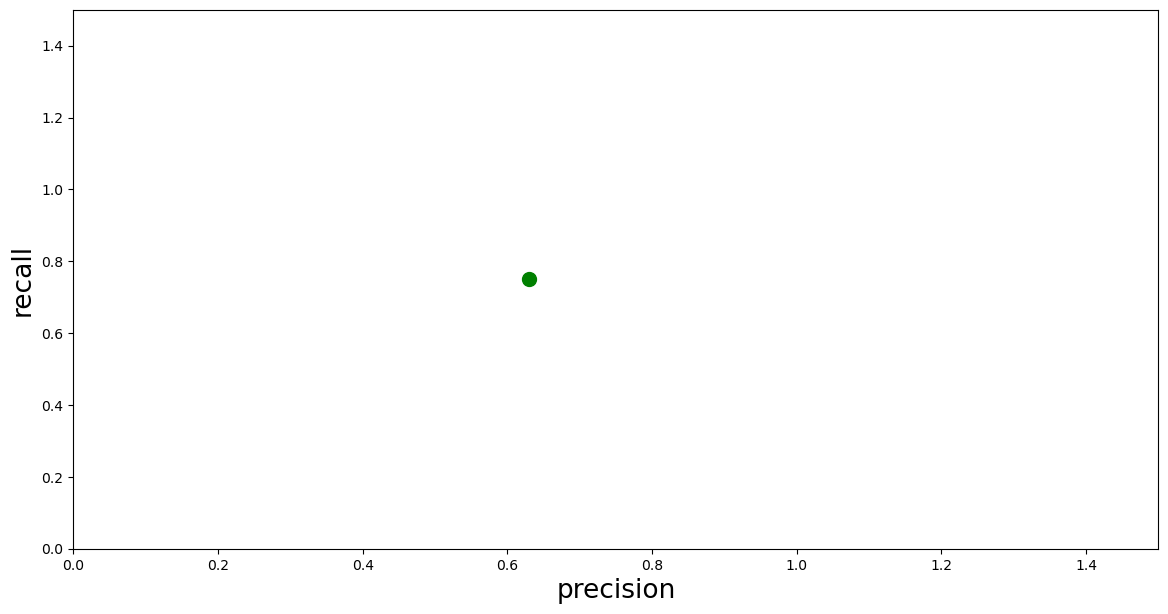

In [162]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "go", markersize = 10)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

For different thresholds, precision and recall will vary. Plotting the precision-recall-points for different thresholds gives the **precision-recall curve**. Bigger area under the curve is better. Pick the threshold at the "corner" of the curve. For this we don't need the label predictions, but the predicted probabilities of the positive class, which we get via `predict_proba()`. 

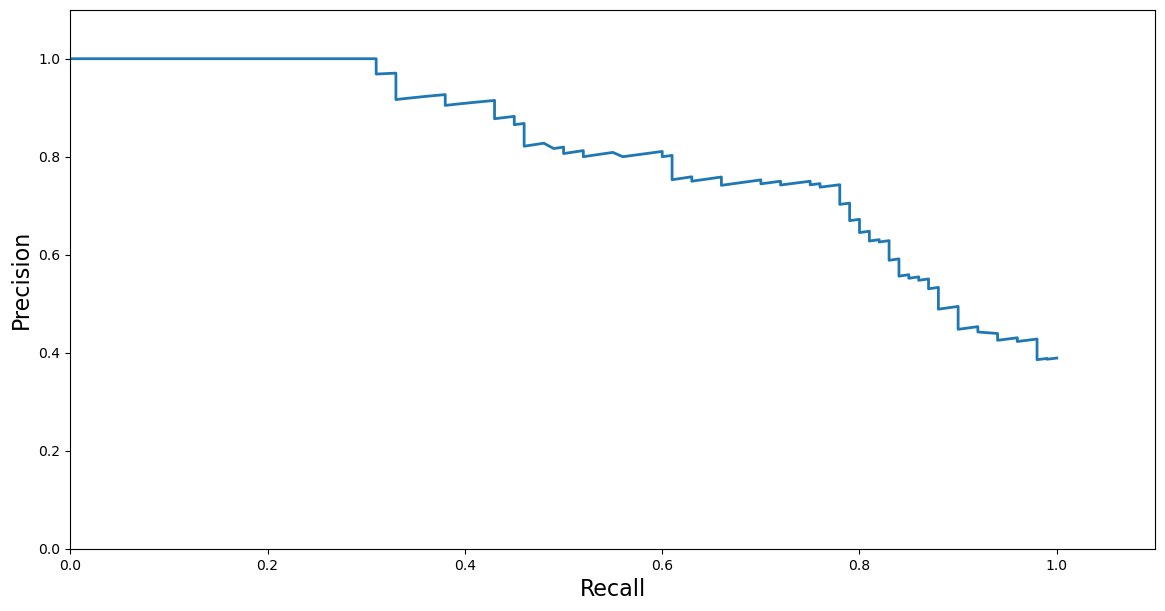

In [163]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = logreg.predict_proba(test_transformed)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(test_labels, y_scores, pos_label='1')

# plotting them against each other
def plot_precision_recall_curve(precision, recall, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
    plt.axis([0, 1.1, 0, 1.1])
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)

plt.figure(figsize=(14, 7))
plot_precision_recall_curve(precision, recall)
plt.show()

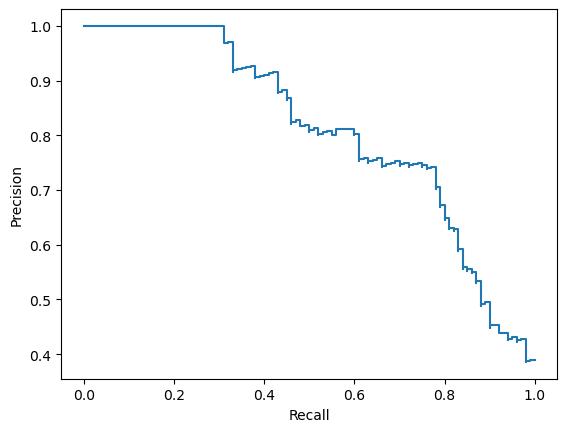

In [164]:
# Alternatively use Sklearn: 

from sklearn.metrics import PrecisionRecallDisplay

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

One metric combining precision and recall is the F1-score:

In [165]:
from sklearn.metrics import f1_score

round(f1_score(test_labels, predictions, pos_label='1'),2)

0.68

A different visual tool to see how good the model is is the **ROC (receiver operating characteristic) curve**, plotting true positive rate vs. false positive rate for varying thresholds. Bigger area under the curve is better. 

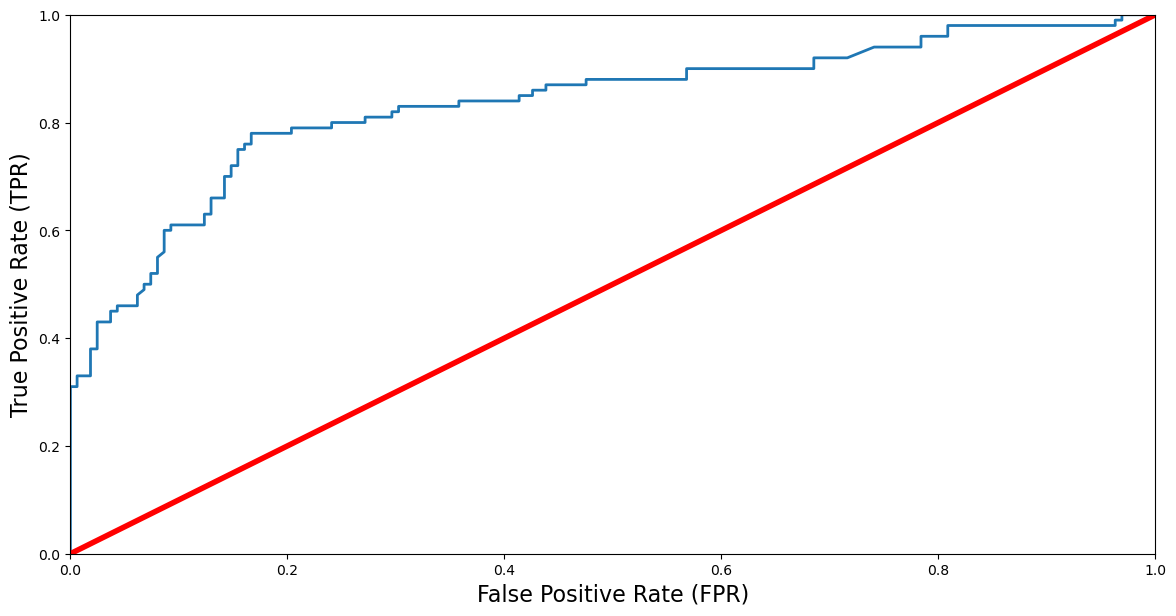

In [166]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_scores, pos_label='1')

# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

A single metric you can get from the ROC score is the area under the curve, the ROC-AUC-Score:

In [167]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(test_labels, y_scores)
print("ROC-AUC-Score:", round(r_a_score,2))



ROC-AUC-Score: 0.84


## Training some more models and comparing their performance

The following are other models for binary classification we will learn this semester: 
- **Random Forest Classifier** is a bunch of **tree classifiers** that work together: you predict the class which is predicted by most of the trees
- **K-Nearest Neighbor (KNN) Classifier**: This is an instance-based model which looks at the K closest instances and predicts the class most of those have
- **Linear Support Vector Classifier (SVC)**: Like Logistic Regression, this finds a linear hyperspace which separates the two classes (but in a more geometric way than logistic regression)


In [168]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_transformed, train_labels)

random_forest_prediction = random_forest.predict(test_transformed)


In [169]:

# Get the accuracy on the training set

acc_random_forest_train = round(random_forest.score(train_transformed, train_labels) * 100, 2)

print('Training accuracy:', round(acc_random_forest_train,2,), "%")

# Get the accuracy on the test set

acc_random_forest_test = round(random_forest.score(test_transformed, test_labels) * 100, 2)

print('Test accuracy:', round(acc_random_forest_test,2,), "%")

Training accuracy: 97.04 %
Test accuracy: 93.51 %


In [170]:
from sklearn.neighbors import KNeighborsClassifier

# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_transformed, train_labels)

knn_prediction = knn.predict(test_transformed)

In [171]:
acc_knn_train = round(knn.score(train_transformed, train_labels) * 100, 2)
print('Training accuracy:', round(acc_knn_train,2,), "%")

acc_knn_test = round(knn.score(test_transformed, test_labels) * 100, 2)
print('Test accuracy:', round(acc_knn_test,2,), "%")

Training accuracy: 85.86 %
Test accuracy: 81.3 %


In [172]:
from sklearn.svm import LinearSVC

# Linear SVC
linear_svc = LinearSVC(max_iter=10000)
linear_svc.fit(train_transformed, train_labels)

svc_prediction = linear_svc.predict(test_transformed)

In [173]:
acc_linear_svc_train = round(linear_svc.score(train_transformed, train_labels) * 100, 2)
print('Training accuracy:', round(acc_linear_svc_train,2,), "%")

acc_linear_svc_test = round(linear_svc.score(test_transformed, test_labels) * 100, 2)
print('Test accuracy:', round(acc_linear_svc_test,2,), "%")

Training accuracy: 80.32 %
Test accuracy: 77.86 %


Compare all results on the test set.

In [174]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest'],
    'Score': [acc_linear_svc_test, acc_knn_test, acc_log_test, 
              acc_random_forest_test]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head()


,Model
Score,
93.51,Random Forest
81.30,KNN
77.86,Support Vector Machines
77.86,Logistic Regression


Compare ROC Curves: This only works for models which can do soft classification. SVC doesn't naturally do that. 

ROC-AUC LogisticRegression 0.84
ROC-AUC RandomForestClassifier 0.97
ROC-AUC KNeighborsClassifier 0.9


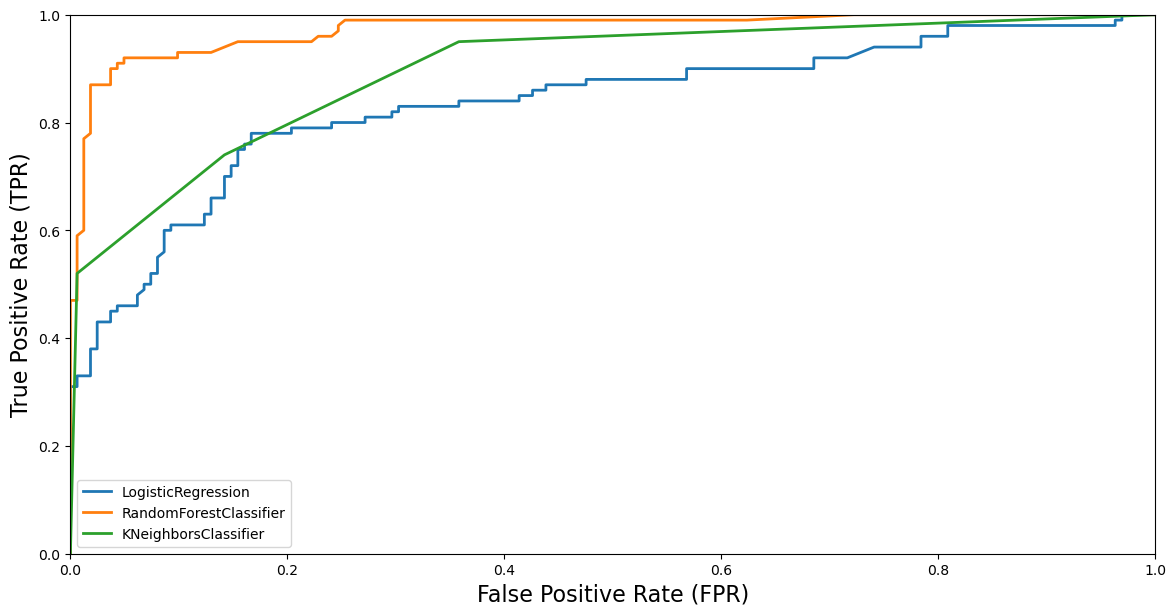

In [175]:
plt.figure(figsize=(14, 7))
for model in [logreg, random_forest, knn]:
    y_scores = model.predict_proba(test_transformed)[:,1]
    # compute true positive rate and false positive rate
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, y_scores, pos_label='1')
    print('ROC-AUC', type(model).__name__, round(roc_auc_score(test_labels, y_scores),2))
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=type(model).__name__)
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate (FPR)', fontsize=16)
plt.ylabel('True Positive Rate (TPR)', fontsize=16)
plt.legend()
plt.show()

### Hyperparameter Tuning for Random Forests

Random Forest Classifiers have several hyperparamters, which we want to tune. How?
- first define a parameter grid. 
- create an object of the class of models you want to finetune. here: a RandomForestClassifier
- create an object of the GridSearchCV-estimator with the above model as an estimator and the parameter grid
- fit the latter
- let the GridSearchCV-object return the best parameters. 
- define the model you want to work with as the `.best_estimator_`

Attention: This might take a while longer than simply training one random forest classifier! For each point in the grid, one model is trained, i.e. in the example below we have 2x6x8x5=480 grid points, i.e. 480 models are trained and evaluated!

In [176]:
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

clf.fit(train_transformed, train_labels)

clf.best_params_

best_rf = clf.best_estimator_

exception calling callback for <Future at 0x2df8b57f0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/homebrew/anaconda3/envs/ml/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'SafeFunction' on <module 'joblib._parallel_backends' from '/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/joblib/_parallel_backends.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
  File "/opt/homebrew/anaconda3/envs/ml/l

Unexpected exception formatting exception. Falling back to standard exception


joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 426, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/opt/homebrew/anaconda3/envs/ml/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'SafeFunction' on <module 'joblib._parallel_backends' from '/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/joblib/_parallel_backends.py'>
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q9/pzd7t_6s2vj1dd9v3l9w99zr0000gq/T/ipykernel_73709/4061602153.py",

Compute the accuracy of this best model and compare it to the old random forest model:

In [ ]:
print('Tuned model accuracy:', round(best_rf.score(test_transformed, test_labels) * 100, 2))
print('Old model accuracy:', round(random_forest.score(test_transformed, test_labels) * 100, 2))

Tuned model accuracy: 82.82
Old model accuracy: 79.39
